# Flights in the United States: 2004 - 2008
## by Maleina Bidek

## Preliminary Wrangling

In this notebook, we will be exploring a dataset that contains flight arrival and departure details for all commercial flights within the United States, including whether or not flights were delayed or cancelled and what the reason was. The data set is from the American Statistical Society and can be found [here.](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009) While the original set contains data from October 1987 to December 2008, in this analysis, we will specifically be exploring data over the five year period from 2004 through 2008.

*Note that while the data set's home page says that it contains records through April 2008, we have seen that it actually contains records through December 2008.*

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

The first thing we need to do is load in our datasets. Each is contained in a .csv file that has been compressed. Because all of the files are structed identically, i.e. they all have the same columns and data types, we can import them sucessively and append them to the same dataframe for further inspection. These sets are quite large, so this could take a while!

In [2]:
# # Read in first data set 
# print("Loading 2004 data...")
# df_flights = pd.read_csv('data/2004.csv.bz2',compression='bz2')

# # Construct list of successive years that need to be imported
# years = np.arange(2005, 2009, 1)

# # Loop through remaining years
# for year in years:
#     # Because loading may take a while, print which dataset we're loading
#     print("Loading " + year.astype(str) + " data...")
#     filename = "data/" + year.astype(str) + ".csv.bz2"
#     df_temp = pd.read_csv(filename, compression='bz2')
#     df_flights = df_flights.append(df_temp)
    
print("Loading 2008 data...")
df_flights_clean = pd.read_csv('data/2008.csv.bz2',compression='bz2')

print("Loading complete!")

Loading 2008 data...
Loading complete!


Next, we'll check to see if we have issues with our data that require cleaning. First, however, let's check the size of our dataset.

In [3]:
#df_flights.shape

We have over 35 million rows and 29 columns. This is a huge set! One of the things we'll need to explore is paring down the set so that computations take less time. Let's do a quick visual check on the set first. Again, since we haven't pared down our set, this could take a little while.

In [4]:
#df_flights

One of the first things that sticks out is that `Year`, `Month` and `DayofMonth` could be combined into a single date field. However, because we don't anticipate conducting a time series analysis, i.e. plotting flight information over time, it actually will be more useful to have these columns separated. This will make it easier for us to aggregate over months or days of the week, for example.

There are also a number of fields that we don't need: `DepTime`, `ArrTime`, `TailNum`, `ActualElapsedTime`, `CRSElapsedTime`, `AirTime`, `Distance`, `TaxiIn`, `TaxiOut`. We can remove these.

`CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, and `LateArrCraftDelay` are columns that are supposed to represent the amount of time spent on that particular type of delay. They are not mutually exclusive: It is possible to have an amount listed in more than one of these columns for the same flight. Note that in this report I generally refer to them as the 'delay reason' columns. Given that we already see that there are null values in some of these fields, we'll want to explore further what to do with these columns.

Because this set is so large, we will first remove the columns that we won't be using. However, just before we start modifying the dataframe, we'll save a new copy.

In [5]:
# Make a copy of our dataset so that we won't have to reload everything 
# if we run into problems cleaning
#df_flights_clean = df_flights.copy()

In [6]:
# Remove unneeded columns
df_flights_clean.drop(['DepTime', 'ArrTime', 'TailNum', 'ActualElapsedTime', 
                 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut'], 
                axis=1, inplace=True)

In [7]:
# Ensure that columns have been removed.
df_flights_clean.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

Let's check our data types next, noting that we'll want to reduce unnessary storage where possible.

In [8]:
df_flights_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   CRSDepTime         int64  
 5   CRSArrTime         int64  
 6   UniqueCarrier      object 
 7   FlightNum          int64  
 8   ArrDelay           float64
 9   DepDelay           float64
 10  Origin             object 
 11  Dest               object 
 12  Cancelled          int64  
 13  CancellationCode   object 
 14  Diverted           int64  
 15  CarrierDelay       float64
 16  WeatherDelay       float64
 17  NASDelay           float64
 18  SecurityDelay      float64
 19  LateAircraftDelay  float64
dtypes: float64(7), int64(9), object(4)
memory usage: 1.0+ GB


Some data types are incorrect. `CRSDepTime` and `CRSArrTime` should be converted to time. `Diverted` and `Cancelled` appear to use 1 for yes and 0 for no and could easily be converted to the more useful Boolean type.  Before we do that let's double check that `Diverted` and `Cancelled` have only the values of 1 (yes) and 0 (no).

In [9]:
df_flights_clean['Diverted'].value_counts()

0    6992463
1      17265
Name: Diverted, dtype: int64

In [10]:
df_flights_clean['Cancelled'].value_counts()

0    6872294
1     137434
Name: Cancelled, dtype: int64

We can see that these two colums have no other values besides zero and one which means that they can easily be converted.

Before we can fix any of our data types, we'll need to check for nulls, as the presence of these could prevent the converstion. Due to the size of our set, this information wasn't present when we called the info() fuction. We'll have to check explicitly.

In [11]:
# Search all columns for nulls and print the number of them.
for row in df_flights_clean.columns:
    print('{}: {}'.format(row, sum(df_flights_clean[row].isna())))

Year: 0
Month: 0
DayofMonth: 0
DayOfWeek: 0
CRSDepTime: 0
CRSArrTime: 0
UniqueCarrier: 0
FlightNum: 0
ArrDelay: 154699
DepDelay: 136246
Origin: 0
Dest: 0
Cancelled: 0
CancellationCode: 6872294
Diverted: 0
CarrierDelay: 5484993
WeatherDelay: 5484993
NASDelay: 5484993
SecurityDelay: 5484993
LateAircraftDelay: 5484993


We will need to investigate the nulls in the `ArrDelay`, `DepDelay`, `CancellationCode`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, and `LateAircraftDelay` columns.

Let's explore `ArrDelay` and `DepDelay` first.

In [12]:
# Seach for records where ArrDelay is null
df_flights_clean[df_flights_clean['ArrDelay'].isna()]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
178,2008,1,3,4,700,830,WN,126,NaN,NaN,LAS,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
373,2008,1,3,4,1100,1215,WN,1146,NaN,NaN,LAX,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
399,2008,1,3,4,905,1025,WN,469,NaN,NaN,LAX,SFO,1,A,0,NaN,NaN,NaN,NaN,NaN
401,2008,1,3,4,1620,1740,WN,618,NaN,NaN,LAX,SFO,1,C,0,NaN,NaN,NaN,NaN,NaN
415,2008,1,3,4,1930,2035,WN,2528,NaN,NaN,LAX,SJC,1,A,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009455,2008,12,13,6,600,815,DL,1211,NaN,NaN,LGA,CVG,1,A,0,NaN,NaN,NaN,NaN,NaN
7009464,2008,12,13,6,1930,2129,DL,1218,NaN,NaN,CVG,LGA,1,A,0,NaN,NaN,NaN,NaN,NaN
7009564,2008,12,13,6,700,1035,DL,1421,NaN,NaN,BOS,FLL,1,A,0,NaN,NaN,NaN,NaN,NaN
7009565,2008,12,13,6,1115,1432,DL,1422,NaN,NaN,FLL,BOS,1,A,0,NaN,NaN,NaN,NaN,NaN


These flights all appear to be cancellations. Let's confirm this by seeing if any nulls exist when canceled is false.

In [13]:
df_flights_clean[(df_flights_clean['ArrDelay'].isna()) & (df_flights_clean['Cancelled']!=1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1763,2008,1,3,4,915,1050,WN,1069,NaN,7.0,SAN,SMF,0,NaN,1,NaN,NaN,NaN,NaN,NaN
1911,2008,1,3,4,1900,2030,WN,2092,NaN,265.0,SFO,SAN,0,NaN,1,NaN,NaN,NaN,NaN,NaN
2651,2008,1,4,5,1905,1910,WN,1403,NaN,44.0,BOI,RNO,0,NaN,1,NaN,NaN,NaN,NaN,NaN
2726,2008,1,4,5,705,825,WN,178,NaN,32.0,BUR,SMF,0,NaN,1,NaN,NaN,NaN,NaN,NaN
3383,2008,1,4,5,930,1145,WN,2011,NaN,1.0,HOU,OAK,0,NaN,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006200,2008,12,10,3,640,859,DL,1610,NaN,34.0,JAN,ATL,0,NaN,1,NaN,NaN,NaN,NaN,NaN
7006401,2008,12,11,4,1106,1950,DL,26,NaN,169.0,LAX,JFK,0,NaN,1,NaN,NaN,NaN,NaN,NaN
7007034,2008,12,11,4,1520,1708,DL,1102,NaN,7.0,IAD,ATL,0,NaN,1,NaN,NaN,NaN,NaN,NaN
7007389,2008,12,11,4,725,945,DL,1491,NaN,-8.0,LGA,MSY,0,NaN,1,NaN,NaN,NaN,NaN,NaN


OK, it looks like a number of these are also diversions. Let's check to see if there are any nulls that are not cancellations nor diversions.

In [14]:
df_flights_clean[(df_flights_clean['ArrDelay'].isna()) & (df_flights_clean['Cancelled']!=1) & (df_flights_clean['Diverted']!=1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


No rows are returned. It appears that the `ArrDelay` column is null only in the case where the flight was cancelled or diverted, which seems correct. We can fill these with 0's to be consistent with other flights in which there was no arrival delay.

In [15]:
# Remove the nulls
df_flights_clean['ArrDelay'].fillna(0, inplace=True)

In [16]:
# Ensure that the nulls have been removed. This should return 0.
sum(df_flights_clean[df_flights_clean['ArrDelay'].isna()].count())

0

Let's check the `DepDelay` column now.

In [17]:
# Seach for records where DepDelay is null
df_flights_clean[df_flights_clean['DepDelay'].isna()]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
178,2008,1,3,4,700,830,WN,126,0.0,NaN,LAS,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
373,2008,1,3,4,1100,1215,WN,1146,0.0,NaN,LAX,OAK,1,A,0,NaN,NaN,NaN,NaN,NaN
399,2008,1,3,4,905,1025,WN,469,0.0,NaN,LAX,SFO,1,A,0,NaN,NaN,NaN,NaN,NaN
401,2008,1,3,4,1620,1740,WN,618,0.0,NaN,LAX,SFO,1,C,0,NaN,NaN,NaN,NaN,NaN
415,2008,1,3,4,1930,2035,WN,2528,0.0,NaN,LAX,SJC,1,A,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009455,2008,12,13,6,600,815,DL,1211,0.0,NaN,LGA,CVG,1,A,0,NaN,NaN,NaN,NaN,NaN
7009464,2008,12,13,6,1930,2129,DL,1218,0.0,NaN,CVG,LGA,1,A,0,NaN,NaN,NaN,NaN,NaN
7009564,2008,12,13,6,700,1035,DL,1421,0.0,NaN,BOS,FLL,1,A,0,NaN,NaN,NaN,NaN,NaN
7009565,2008,12,13,6,1115,1432,DL,1422,0.0,NaN,FLL,BOS,1,A,0,NaN,NaN,NaN,NaN,NaN


These results are similar to what we saw the `ArrDelay` column. Let's check if these are all a result of the flight being cancelled.

In [18]:
df_flights_clean[(df_flights_clean['DepDelay'].isna()) & (df_flights_clean['Cancelled']!=1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


OK, there are no rows returned, which means that if `DepDelay` is null, then the flight was cancelled. This makes sense. Again, we should fill these with 0's for consistency.

In [19]:
# Replace nulls with 0
df_flights_clean['DepDelay'].fillna(0, inplace=True)

In [20]:
# Verify that the nulls have been removed. This should return 0.
sum(df_flights_clean[df_flights_clean['DepDelay'].isna()].count())

0

Next, let's check those nulls in the `CancellationCode` column and see if any occur if cancelled is true (i.e, its 1).

In [21]:
# Check if any nulls exist when the flight was cancelled
df_flights_clean[(df_flights_clean['CancellationCode'].isna()) &
          (df_flights_clean['Cancelled'] == 1)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


No, the nulls are only present when the flight has not been cancelled. We can actually leave these alone as there should be no be no cancellation code unless the flight has been cancelled. Also, since this field will not have its type changed these nulls won't be a problem.

Finally, let's check the nulls in the `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, and `LateAircraftDelay` columns. Let's check if any of these columns are null when there is an arrival or departure delay, i.e. either of the values of `DepDelay` and `ArrDelay` are positive.

In [22]:
# Check if any of the delay reason columns is null when the flight has a 
# positive number of arrival or departure delay minutes.
df_flights_clean[((df_flights_clean['CarrierDelay'].isna()) | 
          (df_flights_clean['WeatherDelay'].isna()) |
          (df_flights_clean['NASDelay'].isna()) |
          (df_flights_clean['SecurityDelay'].isna()) |
          (df_flights_clean['LateAircraftDelay'].isna())) & 
          ((df_flights_clean['ArrDelay'] > 0)|
          (df_flights_clean['DepDelay'] > 0))]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,1955,2225,WN,335,-14.0,8.0,IAD,TPA,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,735,1000,WN,3231,2.0,19.0,IAD,TPA,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,620,750,WN,448,14.0,8.0,IND,BWI,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5,2008,1,3,4,1915,2110,WN,378,11.0,25.0,IND,JAX,0,NaN,0,NaN,NaN,NaN,NaN,NaN
8,2008,1,3,4,615,650,WN,11,2.0,2.0,IND,MCI,0,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009720,2008,12,13,6,800,1026,DL,1633,6.0,-4.0,MSY,ATL,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009722,2008,12,13,6,750,859,DL,1636,2.0,-1.0,SAV,ATL,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009723,2008,12,13,6,959,1150,DL,1636,14.0,3.0,ATL,IAD,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7009726,2008,12,13,6,1240,1437,DL,1639,9.0,11.0,IAD,ATL,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Here we have a number of flights that were actually delayed but no reason was noted. It looks like all of these have arrival delays of less than 15 minutes, however. As a general rule of thumb, 15 minutes is the threshold for calling a flight delayed. Let's check if all arrival delays over 15 minutes have values in these delay reason columns.

In [23]:
# Check if there are nulls in the delay reason columns when 
# a flight has an arrival delay of at least 15 mintues
df_flights_clean[((df_flights_clean['CarrierDelay'].isna()) | 
          (df_flights_clean['WeatherDelay'].isna()) |
          (df_flights_clean['NASDelay'].isna()) |
          (df_flights_clean['SecurityDelay'].isna()) |
          (df_flights_clean['LateAircraftDelay'].isna())) & 
          (df_flights_clean['ArrDelay'] >= 15)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


We can see that all flights with an arrival delay of 15 minutes or more do not have nulls in any of the delay reason columns. Let's check if it is possible to have values in those columns if the arrival delay is less than 15 minutes, or will they all be null?

In [24]:
# Check if there are values in the delay reason columns when 
# a flight has an arrival delay of less than 15 mintues
df_flights_clean[~((df_flights_clean['CarrierDelay'].isna()) & 
          (df_flights_clean['WeatherDelay'].isna()) &
          (df_flights_clean['NASDelay'].isna()) &
          (df_flights_clean['SecurityDelay'].isna()) &
          (df_flights_clean['LateAircraftDelay'].isna())) & 
          (df_flights_clean['ArrDelay'] < 15)]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay


So it is possible that flights with arrival delays of less than 15 minutes will have a value in at least one of the delay reason columns, but we've also seen that they may not. A more interesting result of this query is that there are some records that have a negative departure delay and a negative arrival delay and they don't have nulls. All of the departure reason columns have 0's instead. Given that this means that a non-delayed flight can have 0's in these columns instead of nulls, then for consistency it makes sense to fill our nulls in all of these columns with 0's.

In [25]:
# Remove nulls from each of the delay reason columns 
delay_reason_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for col in delay_reason_cols:
    df_flights_clean[col].fillna(0, inplace=True)

In [26]:
# Ensure that the columns have no more nulls. All should return 0
for col in delay_reason_cols:
    print('# of nulls for '+ col + ': {}'.format(sum(df_flights_clean[df_flights_clean[col].isna()].count())))

# of nulls for CarrierDelay: 0
# of nulls for WeatherDelay: 0
# of nulls for NASDelay: 0
# of nulls for SecurityDelay: 0
# of nulls for LateAircraftDelay: 0


Next, let's finally fix our data types. `Diverted` and `Cancelled` will be converted to Boolean. Other fields will be reduced from 64-bits where possible. We'll address `CRSDepTime` and `CRSArrTime` shortly as their conversion is a bit more complicated. 

In [27]:
# Convert all floats and integers to 16 bit (instead of 32)
# Convert Cancelled and Diverted to boolean
df_flights_clean['Year'] = df_flights_clean['Year'].astype(np.int16)
df_flights_clean['Month'] = df_flights_clean['Month'].astype(np.int16)
df_flights_clean['DayofMonth'] = df_flights_clean['DayofMonth'].astype(np.int16)
df_flights_clean['DayOfWeek'] = df_flights_clean['DayOfWeek'].astype(np.int16)
df_flights_clean['FlightNum'] = df_flights_clean['FlightNum'].astype(np.int16)
df_flights_clean['ArrDelay'] = df_flights_clean['ArrDelay'].astype(np.float16)
df_flights_clean['DepDelay'] = df_flights_clean['DepDelay'].astype(np.float16)
df_flights_clean['Cancelled'] = df_flights_clean['Cancelled'].astype(bool)
df_flights_clean['Diverted'] = df_flights_clean['Diverted'].astype(bool)
df_flights_clean['CarrierDelay'] = df_flights_clean['CarrierDelay'].astype(np.float16)
df_flights_clean['WeatherDelay'] = df_flights_clean['WeatherDelay'].astype(np.float16)
df_flights_clean['NASDelay'] = df_flights_clean['NASDelay'].astype(np.float16)
df_flights_clean['SecurityDelay'] = df_flights_clean['SecurityDelay'].astype(np.float16)
df_flights_clean['LateAircraftDelay'] = df_flights_clean['LateAircraftDelay'].astype(np.float16)

In [28]:
# Verify that our data types have been converted
df_flights_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int16  
 1   Month              int16  
 2   DayofMonth         int16  
 3   DayOfWeek          int16  
 4   CRSDepTime         int64  
 5   CRSArrTime         int64  
 6   UniqueCarrier      object 
 7   FlightNum          int16  
 8   ArrDelay           float16
 9   DepDelay           float16
 10  Origin             object 
 11  Dest               object 
 12  Cancelled          bool   
 13  CancellationCode   object 
 14  Diverted           bool   
 15  CarrierDelay       float16
 16  WeatherDelay       float16
 17  NASDelay           float16
 18  SecurityDelay      float16
 19  LateAircraftDelay  float16
dtypes: bool(2), float16(7), int16(5), int64(2), object(4)
memory usage: 494.7+ MB


Next, lets convert our `CRSDepTime` and `CRSArrTime` columns to dates. We'll actually convert them to the timedelta type, as this will allow us to perform calculations with them.

In [29]:
df_flights_clean['CRSArrTime'].max()

2400

In [30]:
df_flights_clean[df_flights_clean['CRSArrTime']==2400]

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
454781,2008,1,7,1,1115,2400,9E,2807,0.0,15.0,MSP,CID,False,NaN,True,0.0,0.0,0.0,0.0,0.0
455112,2008,1,5,6,805,2400,9E,2825,0.0,71.0,IDA,MSP,False,NaN,True,0.0,0.0,0.0,0.0,0.0
455680,2008,1,17,4,1910,2400,9E,2860,0.0,37.0,MSP,TVC,False,NaN,True,0.0,0.0,0.0,0.0,0.0
455946,2008,1,14,1,921,2400,9E,2874,0.0,6.0,DTW,TVC,False,NaN,True,0.0,0.0,0.0,0.0,0.0
457502,2008,1,16,3,2123,2400,9E,2930,0.0,-3.0,DTW,AVP,False,NaN,True,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267691,2008,9,26,5,730,2400,9E,5881,0.0,-5.0,TYS,DTW,False,NaN,True,0.0,0.0,0.0,0.0,0.0
5268708,2008,9,19,5,1145,2400,9E,5914,0.0,-2.0,BNA,MEM,False,NaN,True,0.0,0.0,0.0,0.0,0.0
5269484,2008,9,28,7,1350,2400,9E,5933,0.0,57.0,MEM,PHL,False,NaN,True,0.0,0.0,0.0,0.0,0.0
5269625,2008,9,19,5,1120,2400,9E,5936,0.0,-4.0,PHL,MEM,False,NaN,True,0.0,0.0,0.0,0.0,0.0


In [31]:
# Convert values of 2400 to 0, as they both represent the same time
df_flights_clean.loc[df_flights_clean['CRSDepTime']==2400]=0
df_flights_clean.loc[df_flights_clean['CRSArrTime']==2400]=0
# Convert the columns by using floor division to extract the hour
# and mod division to extract the minutes. Both the hour and the minutes
# are converted to timedelta format and then added together to get the full time in proper format
df_flights_clean['CRSDepTime'] = (pd.to_timedelta(df_flights_clean['CRSDepTime']//100, unit='h') + 
                            pd.to_timedelta(df_flights_clean['CRSDepTime']%100, unit='m'))
df_flights_clean['CRSArrTime'] = (pd.to_timedelta(df_flights_clean['CRSArrTime']//100, unit='h') + 
                            pd.to_timedelta(df_flights_clean['CRSArrTime']%100, unit='m'))

In [32]:
# Verify the data types are correct
df_flights_clean[['CRSDepTime', 'CRSArrTime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 2 columns):
 #   Column      Dtype          
---  ------      -----          
 0   CRSDepTime  timedelta64[ns]
 1   CRSArrTime  timedelta64[ns]
dtypes: timedelta64[ns](2)
memory usage: 107.0 MB


Finally, let's check for duplicates.

In [33]:
sum(df_flights_clean.duplicated())

550

There are very few duplicates, however, we will still remove these from our set. 

In [34]:
# Drop duplicates
df_flights_clean.drop_duplicates(inplace=True)

In [35]:
# Check that the number of duplicates is now 0.
sum(df_flights_clean.duplicated())

0

Let's take a quick look at our stats.

In [36]:
df_flights_clean.describe()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,ArrDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7.009178e+06,7.009178e+06,7.009178e+06,7.009178e+06,7009178,7009178,7.009178e+06,7009178.0,7009178.0,7009178.0,7009178.0,7009178.0,7009178.0,7009178.0
mean,2.008000e+03,6.375266e+00,1.572803e+01,3.924172e+00,0 days 13:26:18.898116155,0 days 15:08:25.511807518,2.223996e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,7.584556e-01,3.406754e+00,8.797018e+00,1.988259e+00,0 days 04:39:15.752689727,0 days 04:49:46.375306253,1.961629e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:00,0 days 00:00:00,0.000000e+00,-519.0,-534.0,0.0,0.0,0.0,0.0,0.0
25%,2.008000e+03,3.000000e+00,8.000000e+00,2.000000e+00,0 days 09:25:00,0 days 11:15:00,6.220000e+02,-10.0,-4.0,0.0,0.0,0.0,0.0,0.0
50%,2.008000e+03,6.000000e+00,1.600000e+01,4.000000e+00,0 days 13:20:00,0 days 15:17:00,1.571000e+03,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0
75%,2.008000e+03,9.000000e+00,2.300000e+01,6.000000e+00,0 days 17:15:00,0 days 19:07:00,3.517000e+03,11.0,8.0,0.0,0.0,0.0,0.0,0.0
max,2.008000e+03,1.200000e+01,3.100000e+01,7.000000e+00,0 days 23:59:00,0 days 23:59:00,9.743000e+03,2460.0,2468.0,2436.0,1352.0,1357.0,392.0,1316.0


Let's also get a final count of rows and columns.

In [37]:
df_flights_clean.shape

(7009178, 20)

As we progressed through the assessment, we didn't find any other quality issues to be addressed. Therefore, let's save a copy of our cleaned dataset.

In [38]:
#df_flights_final = df_flights_clean.copy()

### What is the structure of your dataset?

As we can see above, our cleaned dataset contains 35,874,671 rows and 20 columns. Most of columns are of a numeric type: `Year`, `Month`, `DayofMonth`, `DayOfWeek` and `FlightNum` are discrete integers, the first four being categorical. `ArrDelay`, `DepDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay` are all continuous float types.

`UniqueCarrier`, `Origin`, `Dest` and `CancellationCode` are categorical text fields. `Cancelled` and `Diverted` have been converted to boolean type. Finally, `CRSDepTime` and `CRSArrTime` have been converted to time types (specifically, timedelta type).

### What is/are the main feature(s) of interest in your dataset?

We're going to be exploring flight cancellations and their reasons. In particular, are there patterns by time of day, time of year, origin and destination? Are particular carriers or flights particularly prone to issues?

Time permitting we may wish to investigate delays in subseqent iterations of this project.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

All of the columns that we've retainted will be of interest, but these in particular: 
- `Month`
- `DayOfWeek`
- `CRSDepTime`
- `CRSArrTime`
- `UniqueCarrier`
- `FlightNum`
- `Origin`
- `Dest`
- `Cancelled`
- `CancellationCode`

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

We will now explore our dataset using various plots.

First, let's look at the distribution of our set of flights over month, day of month and day of week. We want to see how the flights in our dataset are distributed with respect to time of year, days within the month and day of week.  We would expeact that they should be evenly distributed, i.e. there are roughly the same number in each category. If not, that could mean that our dataset has gaps or is incomplete.

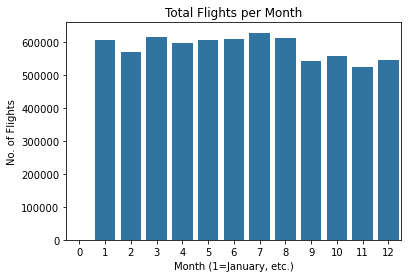

In [39]:
# Select a base color
base_color = sb.color_palette()[0]

# Plot total flights over each month
sb.countplot(data=df_flights_clean, x='Month', color=base_color)
plt.title('Total Flights per Month')
plt.xlabel('Month (1=January, etc.)')
plt.ylabel('No. of Flights');

While there are some slight variations, the number of flights per month is roughly in the same range. Next, let's look at how flights are distributed per calendar day.

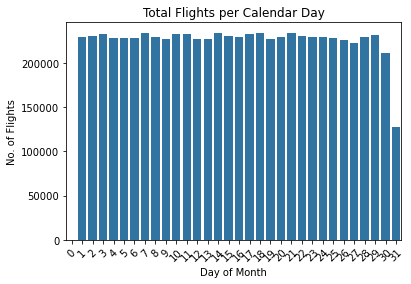

In [40]:
# Plot total flights over each calendar day
sb.countplot(data=df_flights_clean, x='DayofMonth', color=base_color)
plt.title('Total Flights per Calendar Day')
plt.xlabel('Day of Month')
plt.ylabel('No. of Flights')
plt.xticks(rotation=45);

We would expect that the number of flights would be roughly the same for each calendar day. But here we see substantially less for the 31st. This is actually expected due to there being five months every year with 30 days or less. As we saw from our plot above the number of flights per month is roughly the same, so our data set looks pretty evenly distributed with respect to dates. Next, let's look at days of the week.

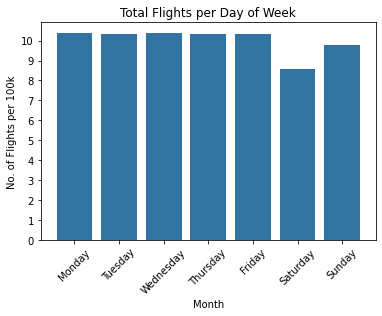

In [41]:
# Set up our axes labels
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ticks = np.arange(0,1100000,100000)
labels = ['{}'.format(v) for v in np.arange(11)]

# Plot total flights over each day of the week
ax=sb.countplot(data=df_flights_clean, x='DayOfWeek', color=base_color)
ax.set(xlim=(0.25, 7.75))
plt.title('Total Flights per Day of Week')
plt.xlabel('Month')
plt.xticks(np.arange(1,8,1), days_of_week, rotation=45)
plt.ylabel('No. of Flights per 100k')
plt.yticks(ticks, labels);

We can see from the above that there are slightly fewer flights on the weekends, Saturday in particular. Again, this is to be expected, as business travel makes up a large proportion of air travel.

Next, let's explore the distribution of our departure and arrival times.

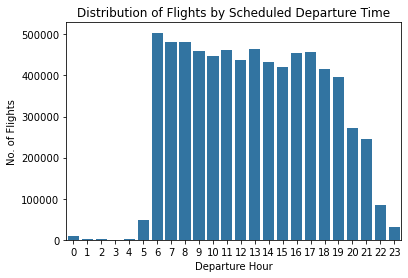

In [42]:
ax=sb.countplot(data=df_flights_clean, x=df_flights_clean['CRSDepTime'].astype('timedelta64[h]'), color=base_color)
plt.title('Distribution of Flights by Scheduled Departure Time')
plt.ylabel('No. of Flights')
plt.xlabel('Departure Hour')
labels=np.arange(0,24,1)
plt.xticks(ticks=ax.get_xticks(),labels=labels);

We can see that there seem to be more flights scheduled earlier in the day from 6am onward, dropping off slightly until around 8pm when they decrease significantly. From midnight to 6am, there are very few scheduled flights.

Let's check schedule arrival times next.

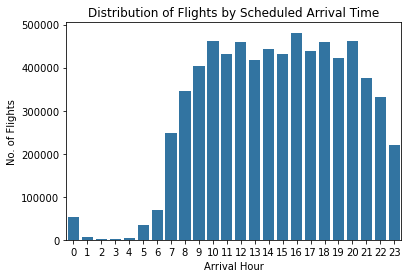

In [43]:
ax=sb.countplot(data=df_flights_clean, x=df_flights_clean['CRSArrTime'].astype('timedelta64[h]'), color=base_color)
plt.title('Distribution of Flights by Scheduled Arrival Time')
plt.ylabel('No. of Flights')
plt.xlabel('Arrival Hour')
labels=np.arange(0,24,1)
plt.xticks(ticks=ax.get_xticks(),labels=labels);

Contrary to scheduled departure times, arrival times seem more normally distributed, increasing from 5am until midmorning, when they remain relatively consistent until they start dropping off around 9pm.

In either case, there don't appear to be any suprises. One would expect that there would be fewer arrivals and departures in the early morning and late evening hours.

Now that we have looked at the distribution of our flights over time, let's explore origins and destinations. Because we're looking at flights in the United States, we expect that there are a large number of both. Let's check our value counts to see how many we're talking about.

In [44]:
df_flights_clean['Origin'].value_counts()

ATL    414511
ORD    350380
DFW    281279
DEN    241441
LAX    215608
        ...  
INL        72
TUP        10
PIR         5
PUB         2
0           1
Name: Origin, Length: 304, dtype: int64

In [45]:
df_flights_clean['Dest'].value_counts()

ATL    414521
ORD    350452
DFW    281400
DEN    241462
LAX    215685
        ...  
TUP         9
PIR         5
OGD         2
CYS         2
0           1
Name: Dest, Length: 305, dtype: int64

So, we've got over 300 destinations and orgins in our dataset. Let's graph the top 20 of each.

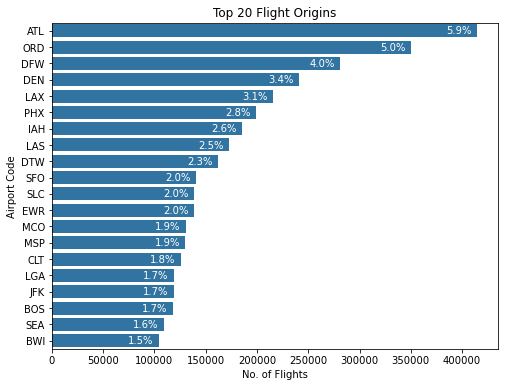

In [46]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))
# Plot total flights over the top 20 origins
top_origins = df_flights_clean['Origin'].value_counts().head(20)
sb.barplot(x=top_origins.values, y=top_origins.index, color=base_color)
plt.title('Top 20 Flight Origins')
plt.ylabel('Airport Code')
plt.xlabel('No. of Flights');

# Calculate count and totals for proportion percentage
type_counts = df_flights_clean['Origin'].value_counts()
n_origins = df_flights_clean['Origin'].value_counts().sum()
# Print the proportion text on the bars
for i in range (20):
    count = type_counts.iloc[i]
    # Format percentage
    pct_string = '{:0.1f}%'.format(100*count/n_origins)
    # Print percentage at end of bar
    plt.text(count-30000, i, pct_string, va='center', color='w')

Atlanta has the most flights in our set, with almost 6% of the total, followed by Chicago O'Hare with 5% of the total.

Let's look at the top 20 destinations next.

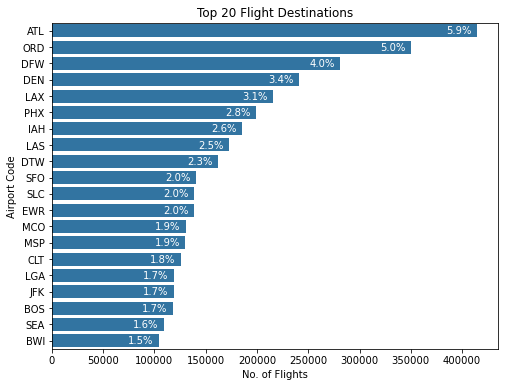

In [47]:
# Set figure size to make the graph easier to read
plt.figure(figsize=(8, 6))
# Plot total flights over the top 20 destinations
top_dests = df_flights_clean['Dest'].value_counts().head(20)
sb.barplot(x=top_dests.values, y=top_dests.index, color=base_color)
plt.title('Top 20 Flight Destinations')
plt.ylabel('Airport Code')
plt.xlabel('No. of Flights');

# Calculate count and totals for proportion percentage
type_counts = df_flights_clean['Dest'].value_counts()
n_dests = df_flights_clean['Dest'].value_counts().sum()
# Print the proportion text on the bars
for i in range (20):
    count = type_counts.iloc[i]
    # Format percentage
    pct_string = '{:0.1f}%'.format(100*count/n_dests)
    # Print percentage at end of bar
    plt.text(count-30000, i, pct_string, va='center', color='w')

This is interesting. They look virtually identical. (I even had to double-check my code!) However, if we print the value counts driving each graph, we'll see why.

In [48]:
df_flights_clean['Origin'].value_counts()[0:20]

ATL    414511
ORD    350380
DFW    281279
DEN    241441
LAX    215608
PHX    199408
IAH    185169
LAS    172875
DTW    161890
SFO    140587
SLC    139088
EWR    138506
MCO    130872
MSP    130239
CLT    126042
LGA    119134
JFK    118804
BOS    117908
SEA    109069
BWI    104073
Name: Origin, dtype: int64

In [49]:
df_flights_clean['Dest'].value_counts()[0:20]

ATL    414521
ORD    350452
DFW    281400
DEN    241462
LAX    215685
PHX    199416
IAH    185158
LAS    172870
DTW    161932
SFO    140579
SLC    139077
EWR    138491
MCO    130859
MSP    130248
CLT    126029
LGA    119101
JFK    118802
BOS    117943
SEA    109075
BWI    104068
Name: Dest, dtype: int64

As we can see, the ordering of the top twenty Origins and Destinations is identical and the counts are also almost identical. Thus, our graphs both look the same. This does make sense if you consider that most routes would likely be designed for a round-trip itinerary.

Next, let's explore carriers. Specifically, let's look at the top 10.

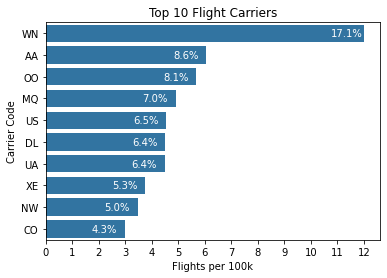

In [50]:
# Plot total flights over the top 10 carriers
ticks = np.arange(0,1300000,100000)
labels = ['{}'.format(v) for v in np.arange(13)]
top_carriers = df_flights_clean['UniqueCarrier'].value_counts().head(10)
sb.barplot(x=top_carriers.values, y=top_carriers.index, color=base_color)
plt.title('Top 10 Flight Carriers')
plt.ylabel('Carrier Code')
plt.xlabel('Flights per 100k')
plt.xticks(ticks, labels);

# Calculate count and totals for proportion percentage
type_counts = df_flights_clean['UniqueCarrier'].value_counts()
n_carriers = df_flights_clean['UniqueCarrier'].value_counts().sum()
# Print the proportion text on the bars
for i in range (10):
    count = type_counts.iloc[i]
    # Format percentage
    pct_string = '{:0.1f}%'.format(100*count/n_carriers)
    # Print percentage at end of bar
    plt.text(count-125000, i, pct_string, va='center', color='w')

We see that Southwest Airlines (WN) had the highest percentage of flights at 17.1%, followed by American (AA) with 8.6%.

Next, let's explore how cancellations and cancellation codes are distributed.

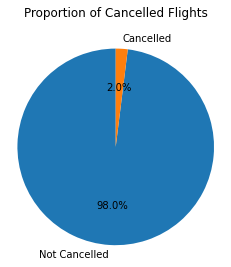

In [51]:
# Sort counts of cancelled vs. non-called flights in prep for plotting
sorted_cancel_counts = df_flights_clean['Cancelled'].value_counts()
# Plot pie chart of proportion of cancelled flights
plt.pie(sorted_cancel_counts, labels = ['Not Cancelled', 'Cancelled'], startangle = 90, autopct='%1.1f%%');
plt.axis('square')
plt.title('Proportion of Cancelled Flights\n');

As we can see above, the overall proportion of flights that were cancelled is actually quite small: 2%. Next, let's look at the reasons that these flights were cancelled.

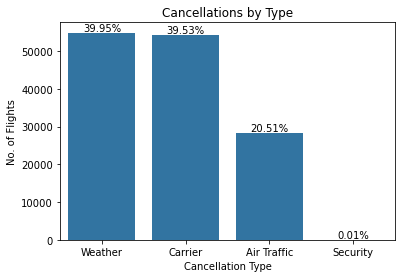

In [52]:
# Plot total flights over each month
#cancelation_codes = A =carrier, B = weather, C = NAS, D = security
code_order = df_flights_clean['CancellationCode'].value_counts().index[0:4]
labels = code_order.map({'A': 'Carrier', 'B': 'Weather', 'C': 'Air Traffic', 'D': 'Security',})
ax=sb.countplot(data=df_flights_clean, x='CancellationCode', color=base_color, order=code_order)
plt.title('Cancellations by Type')
plt.xlabel('Cancellation Type')
plt.xticks(ticks=ax.get_xticks(),labels=labels)
plt.ylabel('No. of Flights')

# Get total count of non-null values in order to calculate proportions    
n_can_type = df_flights_clean['CancellationCode'].value_counts()[0:4].sum()
# Plot the proportion percentage above each bar
for p in ax.patches:
    height = p.get_height()
    pct_string = '{:0.2f}%'.format(100*height/n_can_type)
    ax.text(p.get_x()+ p.get_width()/2.0, height +500, pct_string, ha="center");

The first thing that stands out is that there are relatively few cancellations due to security reasons. Also, Weather and Carrier cancellations we almost equal at 39.95% and 39.53% respectively.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution of flights was quite evenly distributed across time (i.e. months, days of month, days of week). Departure and arrival times were about what one would expect: More departures from 6am to 8pm, gradually tapering off throughout the day, with the fewest from the late evening to the early morning. Arrival times were similar, although they increased gradually over the morning hours, were steady over the day, until gradually tapering off in the evening. This actually makes sense, as flights are scheduled so that they arrive at destinations throughout the day. If any of these variables had not been what we would expect, then it would have raised the question as to whether or not we had a complete set of data for our time period.

In terms of flight cancellations, we saw that overall, cancellations are relatively rare, making up only 2% of the data in our set. Also, the number of cancellations due to security reasons was extremely low (0.01%) as compared to the other three types.

In terms of transformations, there were none to the data itself, this was largely dealt with in the wrangling phase. We did, however, improve the labeling to replace obsure coding (i.e. A, B, C, D) with text descriptions instead.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The distribution of cancellations by type is of note, especially that there is a near equal percentage of weather and carrier related cancellations. According to the [Bureau of Transportation Statistics](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations), carrier related cancellations are when a cancellation "was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.)" I would have assumed that weather cancellations would be more prevalent. 

Another surprise was that the top 20 airports for origins and destinations were virtually identical, including the proportions of each. As noted above, however, this isn't necessarily all that surprising as most flights are likely scheduled with round-trip travel in mind.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!